In [6]:
import os
import sys
dirof = os.path.dirname
sys.path.append('/home/longshen/work/AccGen/AccGen')

import torch
from models.phrase_vae import load_t5_model_from_lit_ckpt, S2SVQAE

ckpt_fp = '/data1/longshen/Results/AccGenResults/bar_compression/s2s/mqcomp_ft/q4_d512_l3_lr1e-4/tb_logs/version_1/checkpoints/epoch=129_step=69420_val_loss=0.0077.ckpt'
t5 = load_t5_model_from_lit_ckpt(ckpt_fp)

model = S2SVQAE(
    tokenizer_path='LongshenOu/phrase-vae-tokenizer',
    t5_config={
        'd_model': 512,
        'd_ff': 1024,
        'num_layers': 3,
        'num_heads': 6,
        'vocab_size': 1000,
        'decoder_start_token_id': 1
    },
    t5_model_name=ckpt_fp,
    lit_ckpt=True,
    compress_style='first_n_tokens',
    n_compress_tokens=4,
)
model.t5 = t5

Skipping key model.vq.embedding.weight as it does not start with 'model.t5.'
Skipping key model.vq.embedding.weight as it does not start with 'model.t5.'
Using compress_style: first_n_tokens


In [7]:
# Prepare tokenizer
from transformers import PreTrainedTokenizerFast
tokenizer_path = 'LongshenOu/phrase-vae-tokenizer'
tok = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)

In [8]:
# Prepare data
from sonata_utils import read_jsonl
jsonl_fp = '/home/longshen/work/AccGen/AccGen/data_preprocess/POP909/statistics/unique_piano_bars.jsonl'
data = read_jsonl(jsonl_fp)
bar1 = data[8]
bar2 = data[108]
print(bar1)
print(bar2)

i-0 o-0 p-30 d-6 o-3 p-66 d-3 p-61 d-3 o-6 p-30 d-3 o-9 p-54 d-3 o-12 p-66 d-3 p-61 d-3 p-30 d-3 o-15 p-54 d-3 o-18 p-66 d-3 p-61 d-3 p-30 d-3 o-21 p-57 d-3 p-30 d-3 o-24 p-66 d-9 p-62 d-9 p-57 d-9 p-38 d-18 p-26 d-6 o-30 p-26 d-6 o-33 p-50 d-6 o-36 p-66 d-6 p-62 d-6 p-57 d-6 p-26 d-3 o-42 p-50 d-6 p-26 d-6 b-1
i-0 o-0 p-35 d-21 o-3 p-42 d-18 o-6 p-47 d-6 o-9 p-54 d-6 o-12 p-63 d-12 o-15 p-47 d-3 o-18 p-59 d-6 o-21 p-54 d-3 o-24 p-34 d-21 o-27 p-51 d-3 o-30 p-54 d-3 o-33 p-51 d-3 o-36 p-61 d-12 o-39 p-51 d-3 o-42 p-54 d-6 o-45 p-51 d-3 b-1


In [ ]:
from piano_roll_utils import save_piano_roll
from remi_z import MultiTrack

# Get latents of the two bars
def get_latents(model, tok, bar_str):
    # Add special tokens
    inp_seq = bar_str.split()
    inp_seq = ['[BOS]'] + inp_seq + ['[EOS]']
    inp_seq = [f'[C{i}]' for i in range(4)] + inp_seq
    bar_str = ' '.join(inp_seq)

    inputs = tok(bar_str, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
    input_ids = inputs.input_ids
    # Debug: detokenize
    # print(tok.batch_decode(input_ids, skip_special_tokens=False))
    attention_mask = inputs.attention_mask
    with torch.no_grad():
        latents = model.encode(input_ids, attention_mask)
    return latents

# Get latents of 100 random bars
latents_list = []
import random
random.seed(42)
from tqdm import tqdm
bar_indices = random.sample(range(len(data)), 1000)
for idx in tqdm(bar_indices):
    bar = data[idx]
    latents = get_latents(model, tok, bar)
    latents_list.append(latents['quantized'][0].numpy())
print(latents_list[0].shape)  # (4, 512)

100%|██████████| 1000/1000 [00:19<00:00, 52.56it/s]

(4, 512)


In [32]:
bar_indices

[41905,
 7296,
 1639,
 48598,
 18024,
 16049,
 14628,
 9144,
 48265,
 6717,
 44348,
 48540,
 35741,
 5697,
 38698,
 27651,
 2082,
 1952,
 6140,
 14328,
 15247,
 33118,
 39453,
 1739,
 36781,
 13031,
 46925,
 42590,
 45962,
 35713,
 27493,
 14446,
 29439,
 38618,
 18231,
 425,
 49729,
 10463,
 45753,
 27696,
 22298,
 18210,
 10189,
 14110,
 50036,
 22059,
 6698,
 6078,
 24898,
 6338,
 23526,
 22541,
 39565,
 17335,
 2847,
 47823,
 30108,
 35142,
 8180,
 24807,
 5164,
 36178,
 19213,
 41198,
 40535,
 23700,
 37837,
 12601,
 46174,
 4558,
 3003,
 43336,
 14935,
 18965,
 5229,
 15256,
 6619,
 24911,
 18217,
 29714,
 41660,
 23909,
 10659,
 24260,
 23283,
 13730,
 43920,
 17496,
 45994,
 44796,
 42469,
 4679,
 39920,
 41613,
 11215,
 35005,
 47784,
 16043,
 10708,
 30294,
 24867,
 17691,
 41943,
 45099,
 36500,
 14392,
 44866,
 21252,
 3665,
 15010,
 2103,
 20673,
 26290,
 17546,
 4337,
 13826,
 37170,
 47049,
 20622,
 13934,
 42954,
 32717,
 25928,
 42129,
 30071,
 9363,
 17359,
 9150,
 16

In [18]:
def get_piano_roll_from_latents(model, tok, latents):
    out = model.decode(
            {'quantized':latents.unsqueeze(0)},
            max_length=128,
            pad_token_id=tok.pad_token_id,
            eos_token_id=tok.eos_token_id,
            do_sample=False,
            num_beams=1,
        )
    # print(out)
    bar_str = tok.decode(out[0], skip_special_tokens=True)
    # print(bar_str)
    bar_mt = MultiTrack.from_remiz_str(bar_str)[0]
    proll = bar_mt.to_piano_roll(pos_per_bar=48)
    return proll, bar_mt



(1000, 2)
Explained variance ratio: [0.03424078 0.02771181]
Cumulative explained variance ratio: [0.03424078 0.06195259]


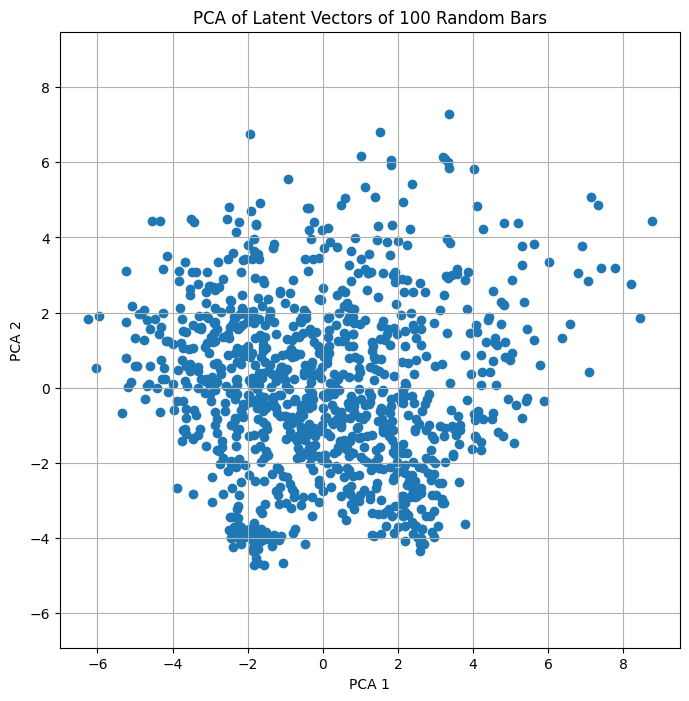

In [20]:
# PCA to 2D
from sklearn.decomposition import PCA
import numpy as np
latents_array = np.array(latents_list)  # (100, 4, 512)
latents_array_2d = latents_array.reshape(latents_array.shape[0], -1)  # (100, 2048)
pca = PCA(n_components=2)
latents_pca = pca.fit_transform(latents_array_2d)  # (100, 2)
print(latents_pca.shape)
print('Explained variance ratio:', pca.explained_variance_ratio_)
print('Cumulative explained variance ratio:', np.cumsum(pca.explained_variance_ratio_))
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(latents_pca[:, 0], latents_pca[:, 1])
# for i, idx in enumerate(bar_indices):
#     plt.annotate(str(idx), (latents_pca[i, 0], latents_pca[i, 1]))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Latent Vectors of 100 Random Bars')
plt.grid()
plt.axis('equal')
plt.show()

(1000, 3)
Explained variance ratio: [0.0342408  0.02771185 0.01981704]
Cumulative explained variance ratio: [0.0342408  0.06195265 0.0817697 ]


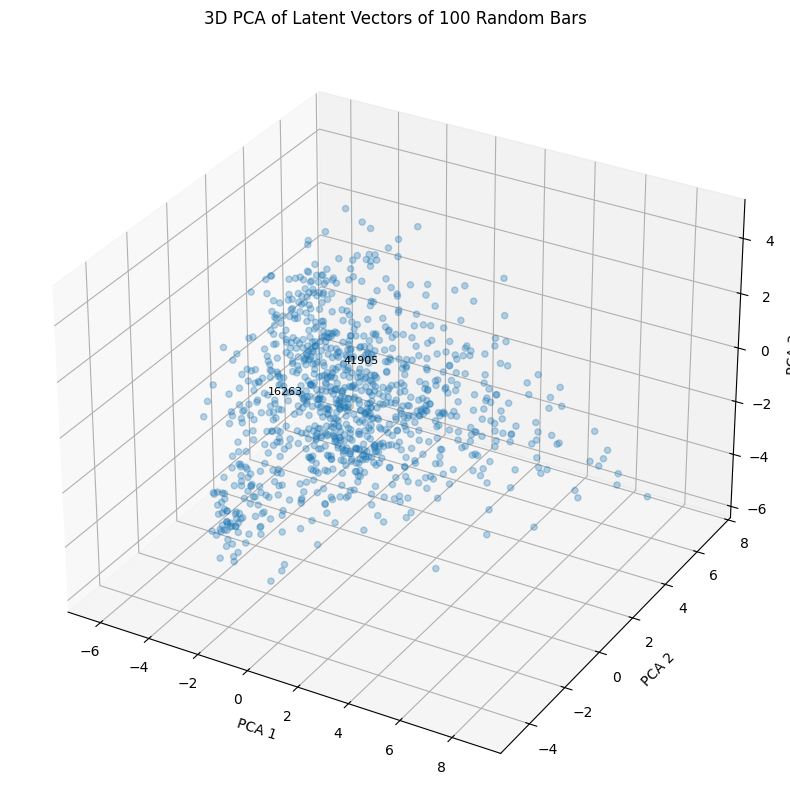

In [23]:
# 3D PCA
from mpl_toolkits.mplot3d import Axes3D
pca_3d = PCA(n_components=3)
latents_pca_3d = pca_3d.fit_transform(latents_array_2d)  # (100, 3)
print(latents_pca_3d.shape)
print('Explained variance ratio:', pca_3d.explained_variance_ratio_)
print('Cumulative explained variance ratio:', np.cumsum(pca_3d.explained_variance_ratio_))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latents_pca_3d[:, 0], latents_pca_3d[:, 1], latents_pca_3d[:, 2], alpha=0.3)
for i, idx in enumerate(bar_indices):
    if i % 500 == 0:  # 每隔 500 个标注一个
        ax.text(latents_pca_3d[i, 0], latents_pca_3d[i, 1], latents_pca_3d[i, 2], str(idx), fontsize=8)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('3D PCA of Latent Vectors of 100 Random Bars')
plt.show()

In [26]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

# 示例：latents_array 是 shape=(N, D) 的 numpy 数组
# bar_indices 是对应的编号 list 或 array，长度为 N

# 降维
pca = PCA(n_components=3)
latents_array_2d = latents_array.reshape(latents_array.shape[0], -1)  # (100, 2048)
latents_pca_3d = pca.fit_transform(latents_array_2d)

# 创建 plotly figure
fig = go.Figure(data=[go.Scatter3d(
    x=latents_pca_3d[:, 0],
    y=latents_pca_3d[:, 1],
    z=latents_pca_3d[:, 2],
    mode='markers+text',
    marker=dict(
        size=3,
        color=np.arange(len(latents_pca_3d)),  # 可换成别的类别标签
        colorscale='Viridis',
        opacity=0.7
    ),
    text=[str(i) if i % 500 == 0 else '' for i in bar_indices],  # 稀疏标注
    textposition='top center'
)])

# 设置图形参数
fig.update_layout(
    title='Interactive 3D PCA of Bar Latents',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    height=800
)

# 显示
fig.write_html("bar_latents_pca.html")

In [35]:
import numpy as np
from sklearn.cluster import KMeans
import plotly.express as px

# 假设这些都已经准备好了
# latents_pca_3d: (N, 3)
# bar_indices: 长度 N 的列表（可以是 sample id 或者 bar index）

# 聚类
kmeans = KMeans(n_clusters=10, random_state=42).fit(latents_pca_3d)
labels = kmeans.labels_

# 构建 text 注释：每 500 个加一次
text_labels = []
for i, idx in enumerate(bar_indices):
    if i % 500 == 0:
        text_labels.append(str(idx))
    else:
        text_labels.append("")  # 空就不会显示

# 构建 hover 信息
hover_texts = [f"Index: {idx}<br>Cluster: {label}" for idx, label in zip(bar_indices, labels)]

# 创建 Plotly 3D 图
fig = px.scatter_3d(
    x=latents_pca_3d[:, 0],
    y=latents_pca_3d[:, 1],
    z=latents_pca_3d[:, 2],
    color=labels.astype(str),
    text=text_labels,         # 显示在图中的 annotation
    hover_name=hover_texts    # 鼠标悬停时显示的信息
)

# 设置文本字体和 hover 样式（可选）
fig.update_traces(textposition='top center', marker=dict(size=3))

# 保存为 HTML
fig.write_html("bar_latents_pca_clustering.html")

Then I try to see the cluster centers

In [40]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=10).fit(latents_array_2d)  # 或 latents_raw
cluster_centers = kmeans.cluster_centers_  # shape: (10, latent_dim)

In [44]:
# 假设你的 decoder 是 model.decode(latent)
from sonata_utils import jpath
save_dir = '/home/longshen/work/AccGen/AccGen/tests/clustering_centers'
cnt = 0
for center in cluster_centers:
    # reshape to (4, 512)
    latent = center.reshape(4, 512)
    latent = torch.from_numpy(latent).float()
    proll, mt = get_piano_roll_from_latents(model, tok, latent)
    save_fp = jpath(save_dir, f'cluster_center_{cnt}.mid')
    mt.to_midi(save_fp)
    cnt += 1


MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_0.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_1.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_2.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_3.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_4.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_5.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_6.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_centers/cluster_center_7.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/clustering_cen